# [02｜无需任何机器学习，如何利用大语言模型做情感分析？](https://time.geekbang.com/column/article/642179)

OpenAI 就只提供了 Complete 和 Embedding 两个接口，其中，Complete 可以让模型根据你的输入进行自动续写，Embedding 可以将你输入的文本转化成向量。

用这么简单的两个 API，能够完成原来需要通过各种 NLP 技术解决的问题吗？比如情感分析、文本分类、文章聚类、摘要撰写、搜索，答案是可以，接下来的几篇内容将讲解怎么利用大语言模型提供的这两个简单的 API 来解决传统的自然语言处理问题。

这一篇，先从一个最常见的自然语言处理问题——“情感分析”开始，来看看我们怎么把大语言模型用起来。

## 1 传统的二分类方法：朴素贝叶斯与逻辑回归

“情感分析”问题，是指我们根据一段文字，去判断它的态度是正面的还是负面的。在传统的互联网产品里，经常会被用来分析用户对产品、服务的评价。比如大众点评里面，你对餐馆的评论，在京东买个东西，你对商品的评论，都会被平台拿去分析，给商家或者餐馆的评分做参考。也有些品牌，会专门抓取社交网络里用户对自己产品的评价，来进行情感分析，判断消费者对自己的产品评价是正面还是负面的，并且会根据这些评价来改进自己的产品。

对于“情感分析”类型的问题，传统的解决方案就是把它当成是一个分类问题，也就是先拿一部分评论数据，人工标注一下这些评论是正面还是负面的。如果有个用户说“这家餐馆真好吃”，那么就标注成“正面情感”。如果有个用户说“这个手机质量不好”，那么就把对应的评论标注成负面的。

...

更多信息可以参考原文。

## 2 大语言模型：20 行代码的情感分析解决方案

通过大语言模型来进行情感分析，最简单的方式就是利用它提供的 Embedding 这个 API。这个 API 可以把任何你指定的一段文本，变成一个大语言模型下的**向量**，也就是用一组固定长度的参数来代表任何一段文本。

我们需要提前计算“好评”和“差评”这两个字的 Embedding。而对于任何一段文本评论，我们也都可以通过 API 拿到它的 Embedding。那么，我们把这段文本的 Embedding 和“好评”以及“差评”通过余弦距离（Cosine Similarity）计算出它的相似度。然后我们拿这个 Embedding 和“好评”之间的相似度，去减去和“差评”之间的相似度，就会得到一个分数。如果这个分数大于 0，那么说明我们的评论和“好评”的距离更近，我们就可以判断它为好评。如果这个分数小于 0，那么就是离差评更近，我们就可以判断它为差评。

下面我们就用这个方法分析一下两条在京东上购买了 iPhone 用户的评论。

In [1]:
# 准备一下环境
from jproperties import Properties
import openai
from openai.embeddings_utils import cosine_similarity, get_embedding
import os

configs = Properties()
with open("../private.properties", 'rb') as config_file:
    configs.load(config_file)

# 设置 OpenAI 的 Key
openai.api_key = configs.get("open_key").data

# 解决 SSLError，参考 https://www.zhihu.com/question/588395420/answer/2928476066。
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

# 封装 open 的请求过程
EMBEDDING_MODEL = "text-embedding-ada-002"

In [6]:
# 获取"好评"和"差评"的向量
positive_review = get_embedding("好评")
negative_review = get_embedding("差评")

# 获取两种评论的向量
positive_example = get_embedding(
    "买的银色版真的很好看，一天就到了，晚上就开始拿起来完系统很丝滑流畅，做工扎实，手感细腻，很精致哦苹果一如既往的好品质")
negative_example = get_embedding("降价厉害，保价不合理，不推荐")


def get_score(sample_embedding):
    return cosine_similarity(sample_embedding, positive_review) - cosine_similarity(sample_embedding, negative_review)


positive_score = get_score(positive_example)
negative_score = get_score(negative_example)
print("好评例子的评分 : %f" % positive_score)
print("差评例子的评分 : %f" % negative_score)

好评例子的评分 : 0.070963
差评例子的评分 : -0.072895


从结果可以看出，京东上的好评通过 Embedding 相似度计算得到的分数是大于 0 的，京东上面的差评，这个分数是小于 0 的。

下面再拿刚才的例子试一下，看看这个方法是不是对所有词语都管用，只是出现的位置不同但含义截然相反的评论，能得到什么样的结果。

In [7]:
good_restaurant = get_embedding("这家餐馆太好吃了，一点都不糟糕")
bad_restaurant = get_embedding("这家餐馆太糟糕了，一点都不好吃")

good_score = get_score(good_restaurant)
bad_score = get_score(bad_restaurant)
print("好评餐馆的评分 : %f" % (good_score))
print("差评餐馆的评分 : %f" % (bad_score))

好评餐馆的评分 : 0.062719
差评餐馆的评分 : -0.074591


从输出可以看出，可以看到，虽然两句话分别是“太好吃”“不糟糕”和“太糟糕”“不好吃”，其实词语都一样，但是大语言模型一样能够帮助我们判断出来他们的含义是不同的，一个更接近好评，一个更接近差评。

## 3 更大的数据集上的真实案例

只举了几个例子，看起来效果还不错。这会不会只是我们运气好呢？下面再来拿一个真实的数据集验证一下，利用这种方法进行情感分析的准确率能够到多少。

下面这段代码，是来自 OpenAI Cookbook 里面的一个例子。它是用同样的方法，来判断亚马逊提供的用户对一些食物的评价，这个评价数据里面，不只有用户给出的评论内容，还有用户给这些食物打了几颗星。这些几颗星的信息，正好可以拿来验证我们这个方法有多准。对于用户打出 1～2 星的，我们认为是差评，对于 4～5 星的，我们认为是好评。

我们可以通过 Pandas，将这个 CSV 数据读取到内存里面。为了避免重新调用 OpenAI 的 API 浪费钱，这个数据集里，已经将获取到的 Embedding 信息保存下来了，不需要再重新计算。

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

每一条评论都用我们上面的方法，和一个预先设定好的好评和差评的文本去做对比，然后看它离哪个近一些。这里的好评和差评，我们写得稍微长了一点，分别是 “An Amazon review with a negative sentiment.” 和 “An Amazon review with a positive sentiment.”。

在计算完结果之后，我们利用 Scikit-learn 这个机器学习的库，将我们的预测值和实际用户打出的星数做个对比，然后输出对比结果。需要的代码，也就不到 20 行。

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



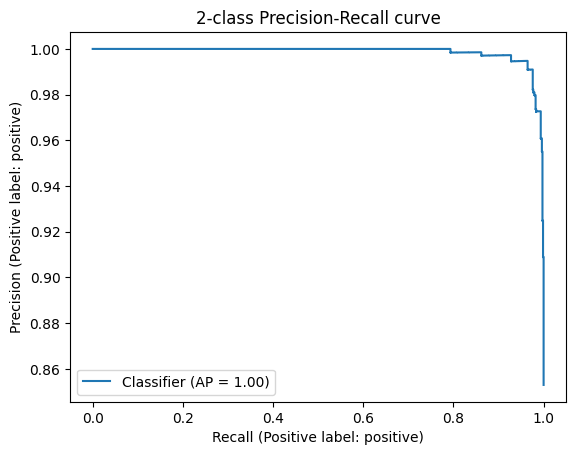

In [3]:
from sklearn.metrics import PrecisionRecallDisplay


def evaluate_embeddings_approach(
        labels=['negative', 'positive'],
        model=EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, engine=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding,
                                                                                            label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x > 0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")


evaluate_embeddings_approach(
    labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])